# Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_diab = pd.read_csv('diabetes.csv')

In [3]:
df_diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df_diab.Outcome.unique()

array([1, 0])

In [38]:
df_diab.shape

(768, 9)

In [5]:
df_diab.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
X = df_diab.drop(['Outcome'],axis=1)
y = df_diab[['Outcome']]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train,y_test = train_test_split(X,
                                                   y, 
                                                   test_size=0.2,
                                                   random_state=12345)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
import tensorflow as tf

In [12]:
from tensorflow.keras.models import Sequential

In [13]:
from tensorflow.keras.layers import Dense, Dropout

In [14]:
tf_model = Sequential()

In [15]:
tf_model.add(Dense(units = 128, 
                   activation = 'relu', 
                   input_shape = (X_train_scaled.shape[1],)))

In [16]:
tf_model.add(Dropout(0.2,seed = 12345))

In [17]:
tf_model.add(Dense(units = 64,
                   activation = 'relu'))

In [18]:
tf_model.add(Dropout(0.2,seed = 12345))

In [19]:
tf_model.add(Dense(units = 1,
                   activation = 'sigmoid'))

In [20]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [21]:
tf_model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

In [22]:
tf_model.fit(X_train_scaled, y_train, epochs = 100)

Epoch 1/100
20/20 [==============================] - 1s 2ms/step - loss: 0.6465 - accuracy: 0.6336
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5412 - accuracy: 0.7248
Epoch 3/100
20/20 [==============================] - 0s 1ms/step - loss: 0.5061 - accuracy: 0.7590
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.7638
Epoch 5/100
20/20 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7883
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7883
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4529 - accuracy: 0.7720
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4592 - accuracy: 0.7769
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4483 - accuracy: 0.7883
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7850
Epoch 11/

In [23]:
y_test_pred = tf_model.predict(X_test_scaled) >= 0.5

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [25]:
confusion_matrix(y_pred = y_test_pred, y_true = y_test)

array([[89, 17],
       [22, 26]])

In [26]:
accuracy_score(y_pred = y_test_pred, y_true = y_test)

0.7467532467532467

# Hyperparameter Tuning

In [27]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 4.5 MB/s  eta 0:00:01


In [28]:
def build_model(hp):
    # Instantiate the model
    model = Sequential()

    # Define first layer -> optimization for number of units and activation function
    model.add(Dense(units = hp.Int("units",min_value = 32, max_value=1024, step=16),
                   activation = hp.Choice("activation",["relu","tanh"]),
                    input_shape = (X_train_scaled.shape[1],)
                   ))
    
    # Define dropout layer by providing the optimization of dropout rate
    model.add(Dropout(hp.Float("rate",min_value=0.1, max_value = 0.4, step=0.1),seed = 12345))

    # Add second layer
    model.add(Dense(units = hp.Int("units",min_value = 32, max_value=128, step=16),
                   activation = hp.Choice("activation",["relu","tanh"])
                   ))
    model.add(Dropout(hp.Float("rate",min_value=0.1, max_value = 0.4, step=0.1),seed = 12345))

    model.add(Dense(units=1, activation='sigmoid'))
    
    # define values for learning rate
    learning_rate = hp.Float("learning_rate",min_value = 0.001, max_value=0.1, step=0.01)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy']
                 )
    return model

In [29]:
import keras_tuner as kt

build_model(kt.HyperParameters())

In [30]:
rtuner = kt.RandomSearch(hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="diab")

In [31]:
rtuner.search(X_train_scaled, y_train, epochs=2, validation_data=(X_test_scaled, y_test))

Trial 3 Complete [00h 00m 01s]
val_accuracy: 0.7045454382896423

Best val_accuracy So Far: 0.7922077775001526
Total elapsed time: 00h 00m 06s
INFO:tensorflow:Oracle triggered exit


In [32]:
models = rtuner.get_best_models(num_models=2)

In [33]:
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 208)               1872      
                                                                 
 dropout (Dropout)           (None, 208)               0         
                                                                 
 dense_1 (Dense)             (None, 208)               43472     
                                                                 
 dropout_1 (Dropout)         (None, 208)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 209       
                                                                 
Total params: 45,553
Trainable params: 45,553
Non-trainable params: 0
_________________________________________________________________


In [36]:
models[1].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               4032      
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 448)               201152    
                                                                 
 dropout_1 (Dropout)         (None, 448)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 449       
                                                                 
Total params: 205,633
Trainable params: 205,633
Non-trainable params: 0
_________________________________________________________________


In [34]:
y_test_pred =  models[0].predict(X_test_scaled) >= 0.5

In [35]:
accuracy_score(y_pred = y_test_pred, y_true = y_test )

0.7922077922077922

In [37]:
rtuner.get_best_hyperparameters()[0].get_config()['values']

{'activation': 'relu',
 'learning_rate': 0.040999999999999995,
 'rate': 0.30000000000000004,
 'units': 208}

# Explainable AI

In [39]:
!pip install shap

     |████████████████████████████████| 564 kB 12.5 MB/s eta 0:00:01


In [40]:
import shap

In [41]:
explainer = shap.KernelExplainer(models[0].predict, X_train_scaled)

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [42]:
features = df_diab.columns

In [43]:
features = features[0:-1]

In [44]:
features

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [45]:
df_diab.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [46]:
shap_values = explainer.shap_values(X_test_scaled[0:20,:])

  0%|          | 0/20 [00:00<?, ?it/s]

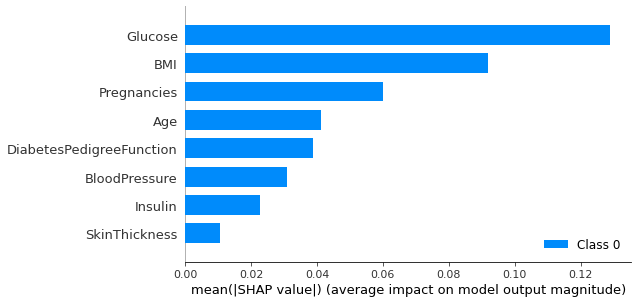

In [47]:
shap.summary_plot(shap_values, X_test_scaled[0:20,:], feature_names = features)